# Initialization

In [40]:
%run utils.ipynb

In [10]:
field_min_x = 0
field_max_x = 15
field_min_y = 0
field_max_y = 10

points0 = [[1,5],
           [2,2],
           [2,8],
           [4,8],
           [5,1],
           [6,6],
           [10,4],
           [10,6],
           [10,8],
           [12,9],
           [12,1],
           [14,6]]

points1 = [[2,8],
          [10,8],
          [6,6]]

points2 = [[2,8],
          [10,8],
          [6,2],
          [6,4],
          [6,6]]

points3 = [[1,1],[1,3],[1,5],[1,7],[1,9],
           [3,1],[3,3],[3,5],[3,7],[3,9],
           [5,1],[5,3],[5,5],[5,7],[5,9],
           [7,1],[7,3],[7,5],[7,7],[7,9],
           [9,1],[9,3],[9,5],[9,7],[9,9],
           [11,1],[11,3],[11,5],[11,7],[11,9],
           [13,1],[13,3],[13,5],[13,7],[13,9]]

points4 = [[1,1],
          [1,4],
          [4,1],
          [4,4],
          [2,2],
          [3,2]]

In [2]:
import random
rnd_x = sorted([random.random() * 15 for i in range(50)])
rnd_y = [random.random() * 10 for i in range(50)]
points5 = [[x, y] for x, y in zip(rnd_x, rnd_y)]

# Calculation

In [12]:
points = points0

all_lines = points_to_lines(points)
all_intersections = lines_to_intersections(all_lines)
nearest_intersections = get_nearest_intersections(points,
                                                  all_lines,
                                                  all_intersections,
                                                  show=False)
segments = get_line_segments(nearest_intersections)

# Results

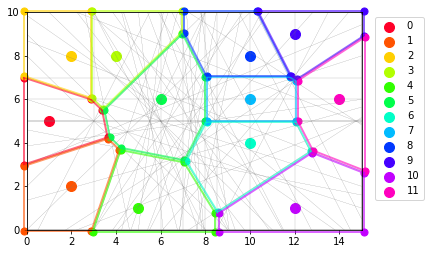

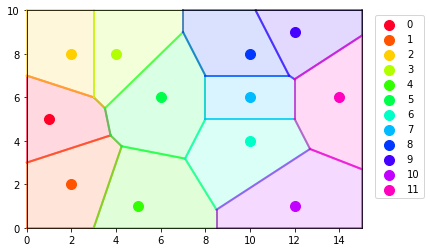

In [37]:
plot(points, all_lines, nearest_intersections, segments)
plot(points, all_lines, nearest_intersections, segments, simple=True, fill=True)

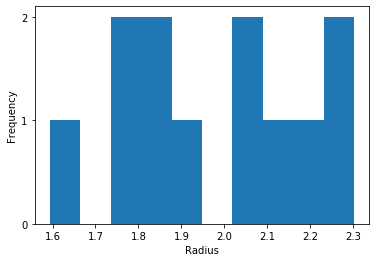

Mean radius     : 1.9827990515409495
SD radius       : 0.22735194624361213
Mean log radius : 0.29461706350489536
SD log radius   : 0.05045662087605344


,area,radius,radius_log
0,10.000000,1.784124,0.251425
1,13.250000,2.053681,0.312533
2,10.500000,1.828183,0.262020
3,11.750000,1.933944,0.286444
4,15.018939,2.186476,0.339745
5,16.590909,2.298054,0.361360
6,14.520360,2.149878,0.332414
7,7.979167,1.593690,0.202404
8,11.000000,1.871205,0.272121
9,9.520833,1.740855,0.240763


In [41]:
#sys.stdout = stdout_backup # print log for get_nearest_intersections()
areas = calculate_areas(nearest_intersections)
areas